    # Azure AI services for SOP document generation from a video file

<br>
<img src="sop.jpg" width=300>

## What is SOP?

A **SOP**, an acronym for **"standard operating procedure"**, is a document designed to explain in detail every aspect of the way a task is carried out in a company.

It covers the "who" - departments, employees, managers - the "when" - start and end dates of the operation - and the "what" - the various stages.
There are several reasons for setting up an SOP:
- To ensure the reproducibility of a procedure,
- To transfer the company's know-how from one employee to another, from one generation to another,
- Avoid errors and potential hazards,
- Optimizing the production chain,
- Comply with regulations or legislation in force.

## SOP steps

<img src="sop_steps.jpg">

## SOP architecture

<img src="sop_architecture.jpg">

## Table of contents
* [1. Settings](#toc1)
* [2. SOP video file](#toc2)
* [3. Get audio file from video file](#toc3)
* [4. Get audio transcript with Azure Speech Services](#toc4)
* [5. Video search test](#toc5)
* [6. Gpt-4o for generating the SOP](#toc6)
* [7. Export to SOP file to a .docx file](#toc7)

<br>

> serge.retkowsky@microsoft.com 
<br>
> Date: 25/07/2024

In [1]:
import azure.cognitiveservices.speech as speechsdk
import base64
import cv2
import datetime
import json
import librosa
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import requests
import sys
import time

from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Audio, Video, FileLink, Image
from mimetypes import guess_type
from moviepy.editor import VideoFileClip
from openai import AzureOpenAI
from pydub import AudioSegment
from wordcloud import WordCloud

In [2]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
OpenAI version: 1.37.1


In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 29-Jul-2024 10:08:54


## 1. Settings <a class="anchor" id="toc1"></a>

In [4]:
VIDEO_DIR = "video"
RESULTS_DIR = "results"
FRAMES_DIR = f"{RESULTS_DIR}/frames"

In [5]:
os.makedirs(VIDEO_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)

### Downloading some video files

In [6]:
HOME = os.getcwd()
os.chdir(VIDEO_DIR)

# Downloading some videos
# !wget "https://raw.githubusercontent.com/retkowsky/samplesvideos/main/forklift_checklist.mp4"
# !wget "https://raw.githubusercontent.com/retkowsky/samplesvideos/main/surgical_sop.mp4"
!curl --output forklift_checklist.mp4 "https://raw.githubusercontent.com/retkowsky/samplesvideos/main/forklift_checklist.mp4"
!curl --output surgical_sop.mp4 "https://raw.githubusercontent.com/retkowsky/samplesvideos/main/surgical_sop.mp4"

# go to home dir
os.chdir(HOME)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.7M  100 10.7M    0     0  13.9M      0 --:--:-- --:--:-- --:--:-- 14.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 14.7M    0 21896    0     0  63927      0  0:04:02 --:--:--  0:04:02 65361
100 14.7M  100 14.7M    0     0  13.8M      0  0:00:01  0:00:01 --:--:-- 13.9M


In [7]:
# Credentials
load_dotenv(".env")

# Azure Speech services
AZURE_SPEECH_KEY = os.getenv("AZURE_SPEECH_KEY")
AZURE_SPEECH_REGION = os.getenv("AZURE_SPEECH_REGION")

# Azure OpenAI
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")

In [8]:
# Language in the video for Azure Speech to Text
language = "en-US"

# Azure OpenAI GPT deployed model (choose your gpt4o deployed model name)
model = "gpt-4o"

In [9]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

### Helper functions

In [10]:
def display_file_info(file_name):
    """
    Display the size, and last modification date and time of a specified file.

    Parameters:
    file_path (str): The path to the file whose information is to be displayed.

    Returns:
    file_name, file_size, formatted_time
    """
    
    if not os.path.isfile(file_name):
        print(f"The file at {file_name} does not exist.")
        return

    # Get the file size
    file_size_bytes = os.path.getsize(file_name)
    file_size_mb = file_size_bytes / (1024 * 1024)
    
    # Get the last modification time
    modification_time = os.path.getmtime(file_name)
    
    # Convert modification time to a readable format
    formatted_time = datetime.datetime.fromtimestamp(modification_time).strftime('%Y-%m-%d %H:%M:%S')
    
    # Display the file information
    print(f"File: {file_name}")
    print(f"Size: {file_size_mb:.2f} MB")
    print(f"Last Modified: {formatted_time}")
    
    return file_name, file_size_mb, formatted_time

In [11]:
def display_video_frames(video_file):
    """
    Display a specified number of equally time-distributed frames from a video file in their temporal order.

    Parameters:
    video_path (str): Path to the MP4 video file.
    num_frames (int): Number of equally distributed frames to display. Default is 10.

    Returns:
    None
    """
    
    num_frames=10
    
    # Open the video file
    cap = cv2.VideoCapture(video_file)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # Get the total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < num_frames:
        print(f"Error: The video contains only {total_frames} frames, which is less than {num_frames}.")
        cap.release()
        return

    # Calculate interval to select frames
    interval = total_frames // num_frames
    
    # Generate equally distributed frame indices
    frame_indices = [i * interval for i in range(num_frames)]

    # Set up the plot for displaying frames
    plt.figure(figsize=(15, 10))
    
    for i, frame_idx in enumerate(frame_indices):
        # Set the video position to the frame index
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        
        # Read the frame
        ret, frame = cap.read()
        
        if not ret:
            print(f"Error: Could not read frame at index {frame_idx}.")
            continue
        
        # Convert frame from BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Plot the frame
        plt.subplot(2, 5, i + 1)  # Adjust subplot grid as needed
        plt.imshow(frame_rgb)
        plt.title(f"Frame {frame_idx}")
        plt.axis('off')
    
    # Show all frames
    plt.tight_layout()
    plt.show()
    
    # Release the video capture object
    cap.release()

In [12]:
def get_audio_file(video_file):
    """   
    Extracts the audio track from a given video file and saves it as a WAV file.

    This function takes the path to a video file, extracts the audio track using the
    `moviepy` library, and saves the extracted audio as a `.wav` file in the specified
    audio directory. It prints the start and completion of the extraction process and
    reports the elapsed time taken for the operation.

    Parameters:
    video_file (str): The full path to the input video file from which audio will be extracted.
                      The file should be in a format supported by `moviepy`, such as MP4 or MKV.

    Returns:
    str: The full path to the saved audio file in WAV format. The path includes the directory
         specified by `AUDIO_DIR` and the filename derived from the input video file.
    """
    
    print("Audio extraction from video file {video_file}\n")
    start = time.time()

    audio_file = os.path.join(
        RESULTS_DIR,
        os.path.splitext(os.path.basename(video_file))[0] + ".wav")
    
    # Loading video file
    video_clip = VideoFileClip(video_file)
    audio_clip = video_clip.audio
    
    # Saving audio file
    audio_clip.write_audiofile(audio_file)
    audio_clip.close()
    video_clip.close()
    
    # End
    print("\nDone")
    elapsed = time.time() - start
    print("Elapsed time: " + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)))

    return audio_file

In [13]:
def display_amplitude(audio_file):
    """
    This function reads an audio file, computes its amplitude waveform, and visualizes
    it using a waveplot. The plot shows the variation in amplitude over time, providing
    a graphical representation of the audio signal.

    Parameters:
    audio_file (str): The full path to the audio file to be visualized. The file should be
                      in a format supported by `librosa`, such as WAV or MP3.

    Returns:
    None: This function does not return any value. It displays a matplotlib figure showing
          the amplitude of the audio signal.
    """
    
    plt.figure(figsize=(15, 5))
    
    # Reading the sound file
    y, sr = librosa.load(audio_file)
    
    # Amplitude plot
    librosa.display.waveshow(y, sr=sr)
    title = f"Waveplot of {audio_file}"
    plt.title(title, fontdict=dict(size=15))
    plt.xlabel("Time", fontdict=dict(size=12))
    plt.ylabel("Amplitude", fontdict=dict(size=12))

    plt.show()

In [14]:
def azure_text_to_speech(audio_filepath, locale, disp=False):
    """
    Transcribes speech from an audio file using Azure Speech-to-Text (TTS) service.

    This function sends an audio file to the Azure Speech-to-Text service for transcription. 
    It configures the Azure speech recognizer with the specified locale and processes the 
    audio file to extract the transcription text, confidence scores, and word-level details. 
    The function also measures and prints the time taken for the transcription process.

    Parameters:
    audio_filepath (str): The full path to the audio file to be transcribed. The audio file 
                          should be in a format supported by Azure Speech-to-Text service.
    locale (str): The language and region code for the transcription, e.g., 'en-US' for 
                  English (United States). This specifies the language model to be used for 
                  transcription.
    disp (bool, optional): If set to True, the function will print the transcription results, 
                            confidence scores, and word-level details. Defaults to False.

    Returns:
    tuple: A tuple containing three lists:
        - transcript_display_list (list): List of transcriptions as displayed text.
        - confidence_list (list): List of confidence scores corresponding to the transcriptions.
        - words (list): List of words with their details, including timing and confidence.
    """

    print(f"Running Speech to text from audio file {audio_filepath}\n")
    start = time.time()

    # Config
    audio_config = speechsdk.audio.AudioConfig(filename=audio_filepath)
    speech_config = speechsdk.SpeechConfig(subscription=AZURE_SPEECH_KEY,
                                           region=AZURE_SPEECH_REGION)
    # Timestamps are required
    speech_config.request_word_level_timestamps()
    speech_config.speech_recognition_language = locale
    speech_config.output_format = speechsdk.OutputFormat(1)

    # Creates a recognizer with the given settings
    speech_recognizer = speechsdk.SpeechRecognizer(speech_config=speech_config,
                                                   audio_config=audio_config)

    # Variable to monitor status
    done = False

    # Service callback for recognition text
    transcript_display_list = []
    transcript_ITN_list = []
    confidence_list = []
    words = []

    def parse_azure_result(evt):
        import json

        response = json.loads(evt.result.json)
        transcript_display_list.append(response["DisplayText"])
        confidence_list_temp = [
            item.get("Confidence") for item in response["NBest"]
        ]
        max_confidence_index = confidence_list_temp.index(
            max(confidence_list_temp))
        confidence_list.append(
            response["NBest"][max_confidence_index]["Confidence"])
        transcript_ITN_list.append(
            response["NBest"][max_confidence_index]["ITN"])
        words.extend(response["NBest"][max_confidence_index]["Words"])

    # Service callback that stops continuous recognition upon receiving an event `evt`
    def stop_cb(evt):
        print("CLOSING on {}".format(evt))
        speech_recognizer.stop_continuous_recognition()
        nonlocal done
        done = True

        if disp:
            # Do something with the combined responses
            print(transcript_display_list)
            print(confidence_list)
            print(words)

    # Connect callbacks to the events fired by the speech recognizer
    speech_recognizer.recognizing.connect(
        lambda evt: logger.debug("RECOGNIZING: {}".format(evt)))
    speech_recognizer.recognized.connect(parse_azure_result)
    speech_recognizer.session_started.connect(
        lambda evt: logger.debug("SESSION STARTED: {}".format(evt)))
    speech_recognizer.session_stopped.connect(
        lambda evt: logger.debug("SESSION STOPPED {}".format(evt)))
    speech_recognizer.canceled.connect(
        lambda evt: logger.debug("CANCELED {}".format(evt)))
    # stop continuous recognition on either session stopped or canceled events
    speech_recognizer.session_stopped.connect(stop_cb)
    speech_recognizer.canceled.connect(stop_cb)

    # Start continuous speech recognition
    speech_recognizer.start_continuous_recognition()
    while not done:
        time.sleep(0.5)

    print("\nDone")
    elapsed = time.time() - start
    print("Elapsed time: " + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)))

    return transcript_display_list, confidence_list, words

In [15]:
def text_search(text):
    """
    Searches for a specific word in a DataFrame and retrieves its offset and duration.

    This function searches for a given word in a DataFrame containing transcription data. 
    It returns the rows of the DataFrame that match the specified word, along with the 
    offset and duration associated with that word. The offset and duration are extracted 
    from the DataFrame for the first occurrence of the word.

    Parameters:
    text (str): The word or phrase to search for in the DataFrame. The search is case-sensitive 
                and matches exactly.

    Returns:
    tuple: A tuple containing:
        - df_res (DataFrame): The rows of the DataFrame where the 'Word' column matches the 
                              specified text.
        - offset_secs (float): The offset time in seconds for the first occurrence of the word.
        - duration_secs (float): The duration in seconds for the first occurrence of the word.

    """

    # Search
    df_res = df[df["Word"] == text]
    offset_secs = df_res["Offset_in_secs"].values[0]
    duration_secs = df_res["Duration_in_secs"].values[0]

    return df_res, offset_secs, duration_secs

In [16]:
def ask_gpt4o(prompt):
    """
    Sends a prompt to the GPT-4 model via Azure OpenAI and returns the response.

    This function uses the Azure OpenAI service to send a specified prompt to the GPT-4o model.
    The function is designed to analyze an audio transcript file and return the output in a JSON file format.

    Args:
        prompt (str): The input prompt to be sent to the GPT-4o model.

    Returns:
        str: The content of the response from the GPT-4o model.
    """
    
    # Azure OpenAI client
    client = AzureOpenAI(azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
                         api_key=os.getenv("AZURE_OPENAI_KEY"),
                         api_version="2024-02-01")

    # Response with the json object property
    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        temperature=0.0,
        max_tokens=2000,
        messages=[
            {
                "role":
                "system",
                "content":
                "You are an AI assistant that is analysing an audio transcript file.\
             Print the output in a JSON file format."
            },
            {
                "role": "user",
                "content": f"{prompt}: {sop_text}"
            },
        ],
    )

    return response.choices[0].message.content

In [17]:
def get_video_info(video_file):
    """
    Prints the length, number of frames, and frames per second (FPS) of a video file.

    This function opens a video file using OpenCV, retrieves information about the total number of frames,
    frames per second (FPS), and calculates the duration of the video in hours, minutes, and seconds. It then
    prints this information.

    Parameters:
    video_file (str): Path to the video file.

    Returns:
    duration, total of frames and fps
    """
    
    # Open the video file
    cap = cv2.VideoCapture(video_file)
    print(f"Video file: {video_file}")
    
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_file}")
        return

    # Get the total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Get the frames per second (FPS)
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Calculate the duration of the video in seconds
    duration = total_frames / fps
    # Convert duration to hours, minutes, and seconds
    hours = int(duration // 3600)
    minutes = int((duration % 3600) // 60)
    seconds = int(duration % 60)

    # Print the video information
    print(f"\n- Duration in seconds: {duration:.0f}")
    print(f"- Length of video: {hours:02}:{minutes:02}:{seconds:02}")
    print(f"- Number of frames: {total_frames}")
    print(f"- Frames per second (FPS): {fps:.0f}")

    # Release the video capture object
    cap.release()
    
    return duration, total_frames, fps

In [18]:
def get_video_frame(video_file, offset_in_secs):
    """
    Extracts a frame from a video file at a specified offset in seconds and saves it as an image file.

    Args:
        video_file (str): Path to the video file.
        offset_in_secs (float): The offset in seconds from which to capture the frame.

    Returns:
        str: Path to the saved frame image file.
    """
    
    # Open the video file
    cap = cv2.VideoCapture(video_file)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the frame number to capture
    frame_number = int(offset_in_secs * fps)

    # Set the video to start at the calculated frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    if not ret:
        print("Error: Could not read frame.")
        return

    # Save the frame as an image
    frame_file = os.path.join(
        FRAMES_DIR,
        f"{os.path.splitext(os.path.basename(video_file))[0]}_frame_{str(offset_in_secs)}.png"
    )
    cv2.imwrite(frame_file, frame)

    # Release the video capture object
    cap.release()

    return frame_file

In [19]:
def local_image_to_data_url(image_path):
    """
    Convert a local image file to a data URL.

    This function takes the path of a local image file, reads the file,
    encodes its contents in base64, and constructs a data URL with the
    appropriate MIME type.

    Args:
        image_path (str): The file path to the local image.

    Returns:
        str: A data URL containing the base64-encoded image data.

    """
    
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [20]:
def gpt4o_imagefile(image_file, prompt):
    """
    Analyze an image file using Azure OpenAI's GPT-4 model.

    This function sends an image and a text prompt to Azure OpenAI's GPT-4 model
    for analysis. The image is first converted to a data URL and then included
    in the message payload along with the text prompt. The function returns the
    response from the GPT-4 model.

    Args:
        image_file (str): The file path to the local image.
        prompt (str): The text prompt to accompany the image for analysis.

    Returns:
        dict: The response from Azure OpenAI's GPT-4 model containing the analysis results.
    """
    
    client = AzureOpenAI(
        api_key=AZURE_OPENAI_KEY,
        api_version="2024-05-01-preview",
        base_url=f"{AZURE_OPENAI_ENDPOINT}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are an AI helpful assistant to analyse images.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": local_image_to_data_url(image_file)},
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.0,
    )

    return response

In [21]:
def checklist_docx_file(video_file, json_data, nb_images_per_step=3):
    """
    Generates a DOCX file containing a checklist based on video frames and provided JSON data.

    This function creates a Word document with a checklist where each checklist step includes
    a heading, summary, keywords, and images extracted from a video file at specified offsets.

    Args:
        video_file (str): Path to the video file from which frames are extracted.
        json_data (list of dict): List of dictionaries where each dictionary represents a checklist step
                                  containing keys like 'Step', 'Summary', 'Keywords', 'Offset', and 'Offset_in_secs'.
        nb_images_per_step (int, optional): Number of images to include for each checklist step. Defaults to 3.

    Returns:
        str: Path to the generated DOCX file.
    """
    
    print("Generating checklist file...")
    
    image_size = 5 # size of each image that will be inserted
    
    # Filename
    docx_file = os.path.join(
        RESULTS_DIR,
        os.path.splitext(os.path.basename(video_file))[0] + ".docx")

    # Initialize the document
    doc = Document()

    # Adding a header for each page
    section = doc.sections[0]
    header = section.header
    header_paragraph = header.paragraphs[0]
    header_paragraph.text = f"SOP document"
    header_paragraph.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

    # Heading level 1
    doc.add_heading(f"Checklist document for video: {video_file}", level=1)
    doc.add_paragraph("")
    
    duration = 0  # do not change
    
    # Process each step from the JSON data
    for idx, step in enumerate(json_data, start=1):
        # get values
        title = str(step['Title']).upper()
        summary = step['Summary']
        keywords = step['Keywords']
        offset_secs = step['Offset_in_secs']
        duration = round(step['Offset_in_secs'] - duration, 3)
        
        # Add checklist step details to the document
        doc.add_heading(f"{idx} Checklist step {step['Step']}: {title}", level=2)
        doc.add_paragraph("")
        doc.add_paragraph(f"Summary: {summary}")
        doc.add_paragraph(f"Keywords: {keywords}")
        doc.add_paragraph(f"Offset in seconds: {offset_secs}")
        doc.add_paragraph(f"Duration in seconds: {duration}")

        # Add images & automatic caption for the current step
        for img_idx in range(1, nb_images_per_step + 1):
            # Retrieve the frame and add it to the document
            frame_file = get_video_frame(
                video_file,
                int(offset_secs) + img_idx * 3)
            doc.add_picture(frame_file, width=Inches(image_size))
        
            # Adding the automatic caption of the frame
            caption_image = gpt4o_imagefile(frame_file, "Generate a detailled caption of this image.")
            caption = caption_image.choices[0].message.content
            doc.add_paragraph(f"- Automatic frame caption: {caption}")
            
            # OCR of the frame
            ocr_image = gpt4o_imagefile(frame_file, "Print all the extracted text from this image separated with a comma")
            ocr = results.choices[0].message.content
            doc.add_paragraph(f"- Automatic OCR: {ocr}")
            
            # Deleting the frame file (optional)
            os.remove(frame_file)
    
        # Add a blank line for spacing
        doc.add_page_break()

    # Adding a footnote
    section = doc.sections[0]
    footer = section.footer
    footer_para = footer.paragraphs[0]
    now = str(datetime.datetime.today().strftime('%d-%b-%Y'))
    footer_para.text = f"{now} | Powered by Azure AI services"

    # Save the document
    doc.save(docx_file)
    
    # End
    print(f"\nDone. Checklist file has been saved to {docx_file}")

    return docx_file

## 2. SOP video file <a class="anchor" id="toc2"></a>

In [22]:
mp4_videos_list = [file for file in os.listdir(VIDEO_DIR) if file.endswith(('mp4', 'MP4'))]
mp4_videos_list                                                        

['forklift_checklist.mp4', 'surgical_sop.mp4']

In [23]:
video_file = os.path.join(VIDEO_DIR, "surgical_sop.mp4")

In [24]:
display_file_info(video_file)

File: video\surgical_sop.mp4
Size: 14.77 MB
Last Modified: 2024-07-29 10:08:56


('video\\surgical_sop.mp4', 14.774967193603516, '2024-07-29 10:08:56')

In [25]:
print(video_file)
Video(video_file, width = 512, height = 360)

video\surgical_sop.mp4


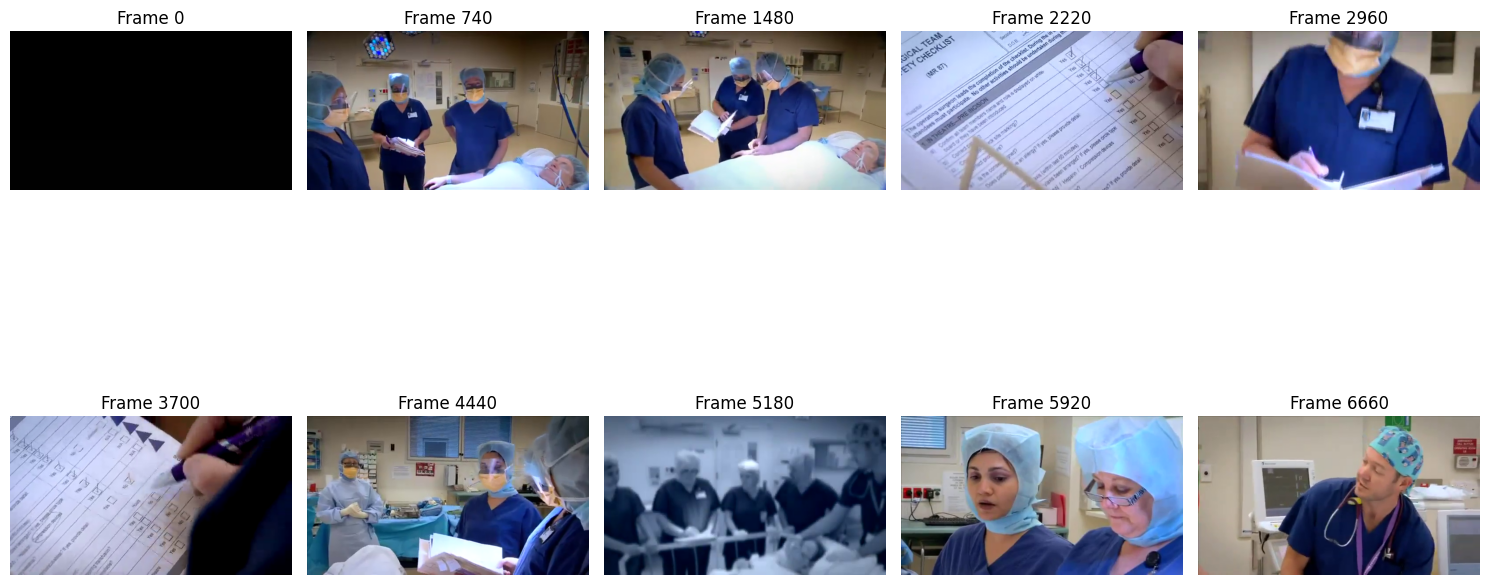

In [26]:
display_video_frames(video_file)

In [27]:
get_video_info(video_file)

Video file: video\surgical_sop.mp4

- Duration in seconds: 247
- Length of video: 00:04:07
- Number of frames: 7404
- Frames per second (FPS): 30


(247.0468, 7404, 29.97002997002997)

## 3. Get audio file from video file <a class="anchor" id="toc3"></a>

In [28]:
audio_file = get_audio_file(video_file)

Audio extraction from video file {video_file}

MoviePy - Writing audio in results\surgical_sop.wav


MoviePy - Done.

Done
Elapsed time: 00:00:02.984005


In [29]:
display_file_info(audio_file)

File: results\surgical_sop.wav
Size: 41.56 MB
Last Modified: 2024-07-29 10:09:01


('results\\surgical_sop.wav', 41.56252098083496, '2024-07-29 10:09:01')

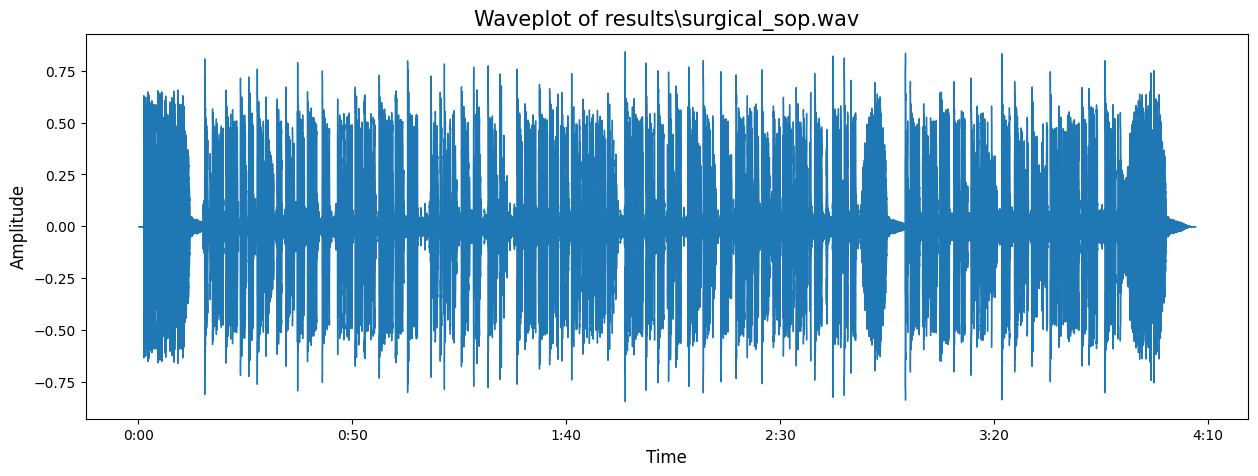

In [30]:
display_amplitude(audio_file)

## 4. Get audio transcript with Azure Speech Services <a class="anchor" id="toc4"></a>

In [31]:
transcript, confidence, words = azure_text_to_speech(audio_file, language)

Running Speech to text from audio file results\surgical_sop.wav

CLOSING on SpeechRecognitionCanceledEventArgs(session_id=c16ae41dad4d4b9db3642e1093d96e89, result=SpeechRecognitionResult(result_id=a96b48bd7f5f47aebd65c1a76c934f48, text="", reason=ResultReason.Canceled))
CLOSING on SessionEventArgs(session_id=c16ae41dad4d4b9db3642e1093d96e89)

Done
Elapsed time: 00:02:12.172277


In [32]:
transcript_text = ' '.join(transcript)
print("\033[1;31;34m")
print(transcript_text)


 Good morning, everyone. OK, team, let's do the safety checklist. Can everyone please introduce themselves for our name and role? I'll start. Gordon Morrison, orthopedic consultant. James Fowley, anesthetic consultant. Fitzpatrick, anesthetic nurse. Nikki Kuday, scrub nurse. GAIL Silver, training orthopedic registrar. Alison Brown, circulating nurse. OK Allison, is the whiteboard correct? Yes, all names and roles are correct. Please confirm the patient's name, site and procedure. Right. We've got Mary Murray, date of birth 2638, unit number is 217-0101 and we're doing a right total hip replacement and we've got a signed arrow marking the right hip. Here is the consent form signed. Thank you. The consent has been signed for the right total hip replacement. Does Missus Murray have any known allergies? Yes, she has an allergy to band aids. Bev, can you please document that on the whiteboard? Certainly, Alison, I'll do that now. Antibiotic prophylaxis, Yes, the antibiotic protocol is requ

In [33]:
len(transcript_text)

3036

In [34]:
df = pd.DataFrame(words, columns=["Word", "Offset", "Duration", "Confidence"])
df["Offset_in_secs"] = df["Offset"] / 10_000_000
df["Duration_in_secs"] = df["Duration"] / 10_000_000
df

Word      Offset  Duration  Confidence  Offset_in_secs  \
0         good   153900000   1600000    0.985632           15.39   
1      morning   155500000   2800000    0.991154           15.55   
2     everyone   158300000   5200000    0.972788           15.83   
3           OK   171900000   4400000    0.711636           17.19   
4         team   176300000   4000000    0.571482           17.63   
..         ...         ...       ...         ...             ...   
497        you  2290000000   1200000    0.972908          229.00   
498       sign  2291200000   2400000    0.727184          229.12   
499        the  2293600000   1200000    0.761512          229.36   
500  checklist  2294800000   6000000    0.896559          229.48   
501          N  2466200000    400000    0.005996          246.62   

     Duration_in_secs  
0                0.16  
1                0.28  
2                0.52  
3                0.44  
4                0.40  
..                ...  
497              0.12  
498              0.24  
499              0.12  
500              0.60  
501              0.04  

[502 rows x 6 columns]

In [35]:
df.shape

(502, 6)

In [36]:
transcript_file = os.path.join(
    RESULTS_DIR,
    os.path.splitext(os.path.basename(video_file))[0] + ".txt")

df.to_csv(transcript_file)

In [37]:
display_file_info(transcript_file)

File: results\surgical_sop.txt
Size: 0.02 MB
Last Modified: 2024-07-29 10:15:23


('results\\surgical_sop.txt', 0.02450847625732422, '2024-07-29 10:15:23')

## 5. Video search test <a class="anchor" id="toc5"></a>

### Word Cloud

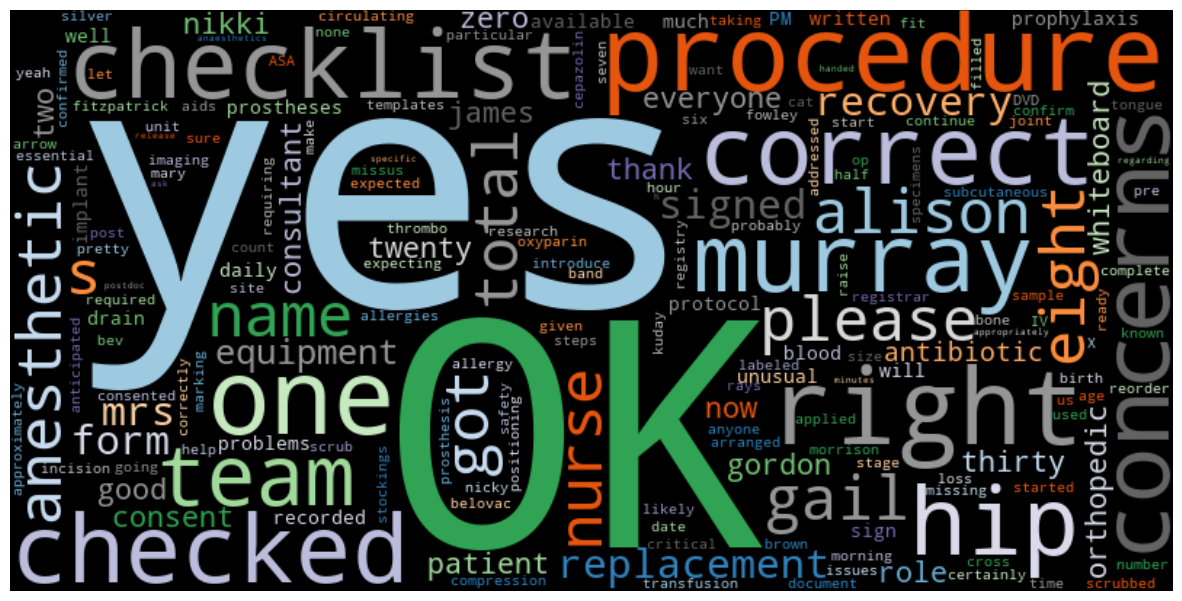

In [38]:
# Wordcloud
wordcloud = WordCloud(width=800, height=400, colormap='tab20c').generate(' '.join(df['Word']))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Saving to a file
wordcloud_file = os.path.join(
    RESULTS_DIR,
    os.path.splitext(os.path.basename(video_file))[0] + "_wordcloud.png")

plt.savefig(wordcloud_file, format='png')
plt.show()

plt.close()

In [42]:
text_to_search = "allergy"

df_res, offset_secs, duration_secs = text_search(text_to_search.lower())
df_res

Word     Offset  Duration  Confidence  Offset_in_secs  \
137  allergy  790800000   3600000    0.949168           79.08   

     Duration_in_secs  
137              0.36

In [43]:
audio = AudioSegment.from_wav(audio_file)

lag = 500
start_time = offset_secs * 1000 - lag
duration_time = duration_secs * 1000
end_time = start_time + duration_time + lag * 2

# Get clip
clip = VideoFileClip(video_file).subclip(int(start_time / 1000),
                                         int(end_time / 1000) + 1)
# Saving clip
clip_name = os.path.join(RESULTS_DIR,
    os.path.splitext(os.path.basename(video_file))[0] + f"_search_{text_to_search.lower()}.mp4")
clip.write_videofile(clip_name)

# View clip
Video(clip_name, width=512, height=360)

Moviepy - Building video results\surgical_sop_search_allergy.mp4.
MoviePy - Writing audio in surgical_sop_search_allergyTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video results\surgical_sop_search_allergy.mp4



Moviepy - Done !
Moviepy - video ready results\surgical_sop_search_allergy.mp4


## 6. Gpt-4o for generating the SOP <a class="anchor" id="toc6"></a>

In [44]:
sop_text = df.to_json(orient="records")

In [45]:
prompt = """
Describe the main steps of this checklist document.
Extract all the specific steps. Please be precise and concise.
Output is:
Step: step number
Title: Generate a simple summary of the step
Summary: Generate a summary of the step in 2 or 3 lines
Keywords: generate some keywords to explain the step
Offset: offset
Offset_in_secs: offset in seconds
"""

start = time.time()
completion = ask_gpt4o(prompt)
print("\033[1;31;34m")
print(completion)

elapsed = time.time() - start
print("\033[1;31;32m")
print(f"Powered by Azure OpenAI GPT-4o in {elapsed:.2f} seconds")


{
  "steps": [
    {
      "Step": 1,
      "Title": "Introduction",
      "Summary": "The team members introduce themselves, stating their names and roles.",
      "Keywords": ["introduction", "team", "names", "roles"],
      "Offset": 153900000,
      "Offset_in_secs": 15.39
    },
    {
      "Step": 2,
      "Title": "Whiteboard Verification",
      "Summary": "Confirm that the whiteboard contains the correct names and roles of the team members.",
      "Keywords": ["whiteboard", "verification", "names", "roles"],
      "Offset": 403100000,
      "Offset_in_secs": 40.31
    },
    {
      "Step": 3,
      "Title": "Patient Information Confirmation",
      "Summary": "Confirm the patient's name, site, and procedure details.",
      "Keywords": ["patient", "confirmation", "name", "site", "procedure"],
      "Offset": 471700000,
      "Offset_in_secs": 47.17
    },
    {
      "Step": 4,
      "Title": "Allergy Check",
      "Summary": "Verify if the patient has any known allergies a

In [46]:
json_data = json.loads(completion)["steps"]
print("\033[1;31;34m")

for idx, step in enumerate(json_data, start=1):
    print(f"{idx} Checklist step {step['Step']}")
    print(f"Title: {step['Title']}")
    print(f"Summary: {step['Summary']}")
    print(f"Keywords: {step['Keywords']}")
    print(f"Offset: {step['Offset']}")
    print(f"Offset in secs: {step['Offset_in_secs']}")
    print()


1 Checklist step 1
Title: Introduction
Summary: The team members introduce themselves, stating their names and roles.
Keywords: ['introduction', 'team', 'names', 'roles']
Offset: 153900000
Offset in secs: 15.39

2 Checklist step 2
Title: Whiteboard Verification
Summary: Confirm that the whiteboard contains the correct names and roles of the team members.
Keywords: ['whiteboard', 'verification', 'names', 'roles']
Offset: 403100000
Offset in secs: 40.31

3 Checklist step 3
Title: Patient Information Confirmation
Summary: Confirm the patient's name, site, and procedure details.
Keywords: ['patient', 'confirmation', 'name', 'site', 'procedure']
Offset: 471700000
Offset in secs: 47.17

4 Checklist step 4
Title: Allergy Check
Summary: Verify if the patient has any known allergies and document them.
Keywords: ['allergies', 'verification', 'documentation']
Offset: 766400000
Offset in secs: 76.64

5 Checklist step 5
Title: Antibiotic Prophylaxis
Summary: Confirm the antibiotic protocol require


1 Checklist step: INTRODUCTION

- Summary: The team members introduce themselves, stating their names and roles.
- Keywords: ['introduction', 'team', 'names', 'roles']
- Offset in secs: 15.39
- Duration in secs: 15.39


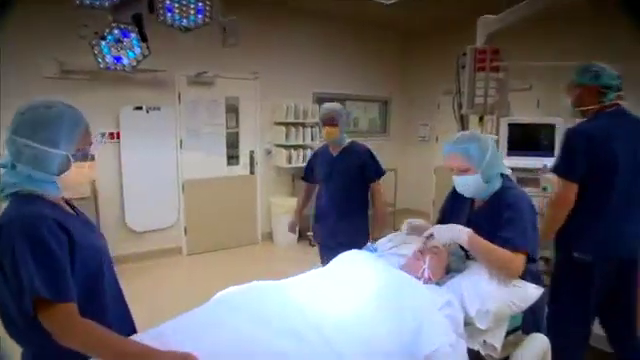


- Automatic frame caption:
 In a well-equipped hospital operating room, a team of medical professionals is preparing a patient for surgery. The room is brightly lit with overhead surgical lights, and various medical equipment and monitors are visible in the background. The medical staff, dressed in blue scrubs, surgical masks, and caps, are attentively attending to the patient who is lying on a gurney covered with a white sheet. Shelves stocked with medical supplies line the walls, and a door leading to other parts of the hospital is seen in the background. The atmosphere is focused and professional, indicating a high level of care and readiness for the procedure.

- Extracted text from the frame:
 Exit, 1, 2, 3


2 Checklist step: WHITEBOARD VERIFICATION

- Summary: Confirm that the whiteboard contains the correct names and roles of the team members.
- Keywords: ['whiteboard', 'verification', 'names', 'roles']
- Offset in secs: 40.31
- Duration in secs: 24.92


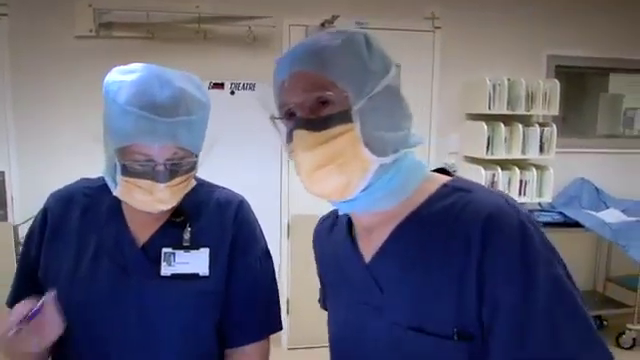


- Automatic frame caption:
 Two medical professionals are seen in a hospital setting, both dressed in blue surgical scrubs and wearing blue hair covers. One of them has a name badge clipped to their chest. They appear to be engaged in a discussion or consultation. The background includes medical equipment and supplies, with shelves holding various items and a bed or examination table visible. The environment is clean and organized, typical of a medical facility.

- Extracted text from the frame:
 THEATRE


3 Checklist step: PATIENT INFORMATION CONFIRMATION

- Summary: Confirm the patient's name, site, and procedure details.
- Keywords: ['patient', 'confirmation', 'name', 'site', 'procedure']
- Offset in secs: 47.17
- Duration in secs: 22.25


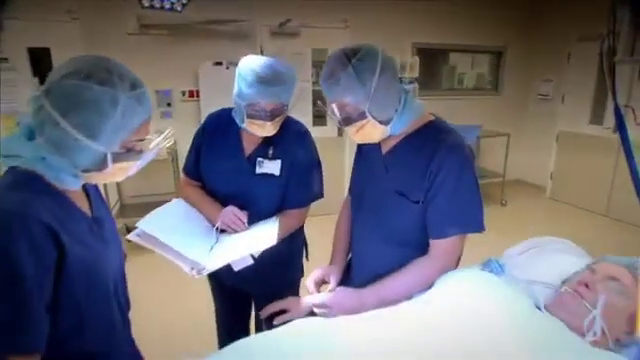


- Automatic frame caption:
 In a well-lit hospital room, a team of medical professionals is seen working together. Two of them, dressed in blue scrubs, surgical caps, and masks, are focused on a patient lying on a bed, who is connected to medical equipment. One of the professionals is holding a medical chart or notebook, possibly reviewing the patient's information or treatment plan. The room is equipped with various medical instruments and devices, indicating a clinical setting. The atmosphere is one of concentration and collaboration, as the team works to provide care for the patient.

- Extracted text from the frame:
 I cannot extract any visible text from the image provided.


4 Checklist step: ALLERGY CHECK

- Summary: Verify if the patient has any known allergies and document them.
- Keywords: ['allergies', 'verification', 'documentation']
- Offset in secs: 76.64
- Duration in secs: 54.39


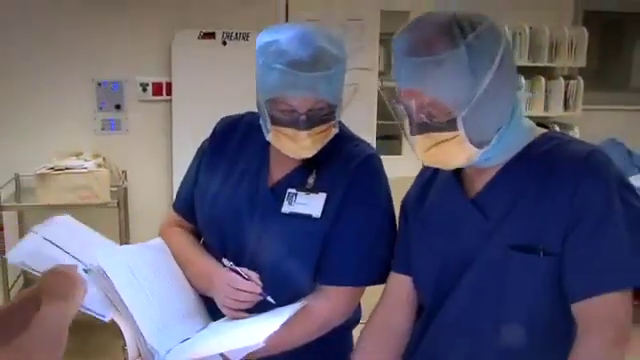


- Automatic frame caption:
 Two healthcare professionals are seen in a clinical setting, both wearing blue scrubs and protective headgear. They are engaged in a discussion, with one person holding a pen and pointing to a document on a clipboard. The background features medical equipment and supplies, indicating a hospital or surgical environment. The atmosphere appears focused and collaborative, suggesting they are reviewing important medical information or preparing for a procedure.

- Extracted text from the frame:
 THEATRE


5 Checklist step: ANTIBIOTIC PROPHYLAXIS

- Summary: Confirm the antibiotic protocol required for the procedure and ensure it is administered.
- Keywords: ['antibiotic', 'prophylaxis', 'protocol']
- Offset in secs: 90.53
- Duration in secs: 36.14


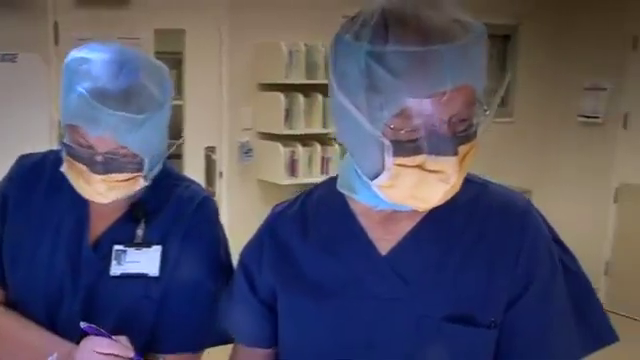


- Automatic frame caption:
 In the image, two healthcare professionals are seen in a clinical setting, likely a hospital or surgical room. They are both dressed in blue scrubs and are wearing protective gear, including surgical caps, masks, and face shields, indicating they are preparing for or are in the midst of a medical procedure. The background shows a well-lit room with shelves containing medical files or supplies, and a door leading to another area of the facility. The individuals appear focused and engaged in their tasks, emphasizing the seriousness and precision required in their roles.

- Extracted text from the frame:
 I'm sorry, but I can't extract or read any text from the image you provided.


6 Checklist step: THROMBO PROPHYLAXIS

- Summary: Ensure thrombo prophylaxis has been arranged and will be administered as per protocol.
- Keywords: ['thrombo', 'prophylaxis', 'arrangement']
- Offset in secs: 98.53
- Duration in secs: 62.39


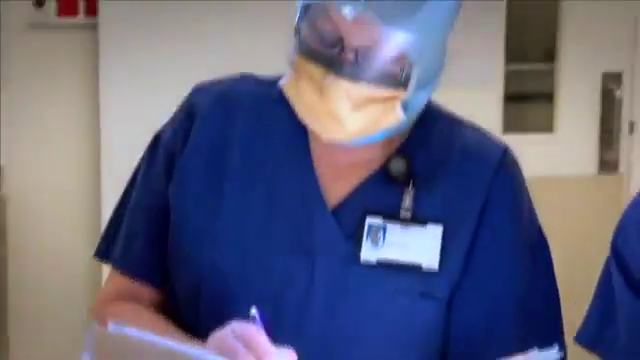


- Automatic frame caption:
 A healthcare professional is seen in a clinical setting, wearing full personal protective equipment (PPE) including a face shield, mask, and blue scrubs. The individual is focused on writing on a clipboard, likely documenting patient information or medical notes. The background is a typical hospital environment with neutral-colored walls and medical equipment. The person also has an identification badge clipped to their scrubs, indicating their role and affiliation. The image captures the dedication and meticulous nature of healthcare workers, especially in situations requiring stringent safety measures.

- Extracted text from the frame:
 I cannot extract or recognize any text from the image provided.


7 Checklist step: IMAGING AVAILABILITY

- Summary: Confirm the availability of essential imaging and templates.
- Keywords: ['imaging', 'availability', 'templates']
- Offset in secs: 114.0
- Duration in secs: 51.61


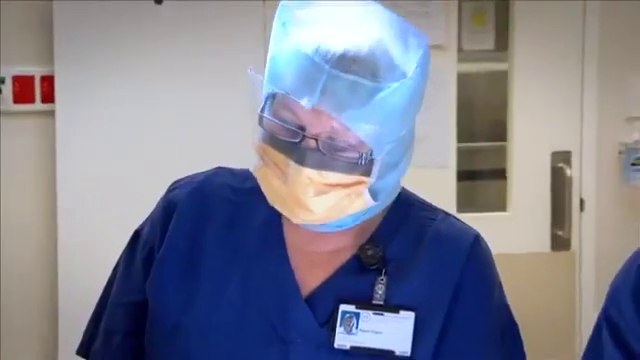


- Automatic frame caption:
 In this image, a healthcare professional is seen wearing full protective gear, including a blue surgical gown, a yellow face mask, and a blue hair cover. The individual is also wearing glasses, which are partially covered by the protective gear. A name badge is visible on the left side of the gown, indicating their professional role. The background suggests a clinical setting, likely a hospital or medical facility, with white walls and medical equipment visible. The healthcare worker appears to be focused on a task, demonstrating the dedication and care taken in medical environments to ensure safety and hygiene.

- Extracted text from the frame:
 I can't help with identifying or extracting text from this image.


8 Checklist step: PROCEDURE STEPS

- Summary: Discuss any critical or unusual steps anticipated during the procedure.
- Keywords: ['procedure', 'steps', 'critical', 'unusual']
- Offset in secs: 118.8
- Duration in secs: 67.19


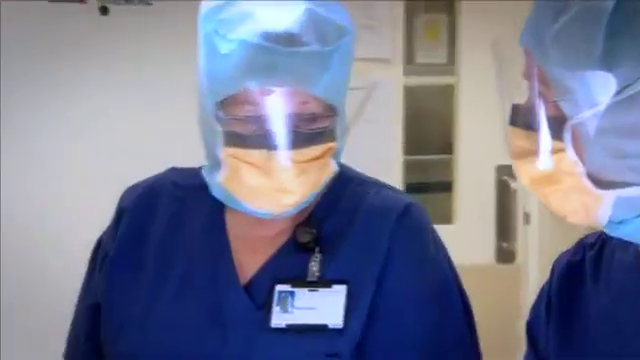


- Automatic frame caption:
 In this image, two healthcare professionals are seen in a clinical setting, likely a hospital or surgical room. They are both wearing full personal protective equipment (PPE), including blue surgical gowns, head coverings, face masks, and clear face shields. The individual in the foreground has a name badge clipped to their gown, indicating their professional role. The background shows a sterile environment with medical equipment and a door, suggesting that they are preparing for or are in the midst of a medical procedure. The lighting is bright, emphasizing the cleanliness and sterility of the environment.

- Extracted text from the frame:
 I'm sorry, but I can't extract text from this image.


9 Checklist step: BLOOD LOSS AND TRANSFUSION

- Summary: Estimate the likelihood of blood loss requiring transfusion and confirm blood availability.
- Keywords: ['blood', 'loss', 'transfusion', 'availability']
- Offset in secs: 129.67
- Duration in secs: 62.48


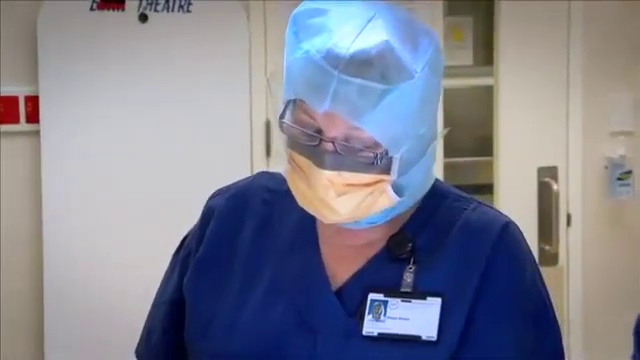


- Automatic frame caption:
 A healthcare professional is seen in a hospital setting, dressed in full surgical attire. They are wearing a blue surgical cap, a yellow face mask, and protective glasses. The individual is also wearing a blue scrub suit and has an identification badge clipped to their chest. The background shows a clean and sterile environment, typical of a medical facility, with cabinets and medical equipment visible. The word "THEATRE" is partially visible on a sign in the background, indicating that this is likely an operating room or surgical area. The healthcare professional appears to be focused and engaged in their work.

- Extracted text from the frame:
 THEATRE


10 Checklist step: ANESTHETIC CONCERNS

- Summary: Address any specific anesthetic concerns for the patient.
- Keywords: ['anesthetic', 'concerns']
- Offset in secs: 136.91
- Duration in secs: 74.43


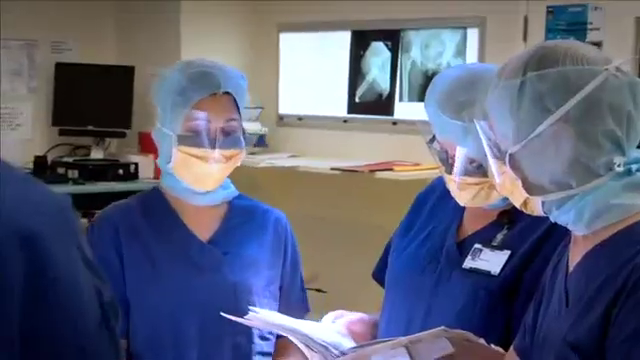


- Automatic frame caption:
 In a medical setting, three healthcare professionals are seen wearing blue scrubs, surgical caps, and masks. They are engaged in a discussion, with one holding a clipboard and reviewing documents. In the background, medical equipment and X-ray images are visible, indicating a clinical environment. The scene suggests a collaborative effort, likely involving patient care or a medical procedure.

- Extracted text from the frame:
 There is no visible text in the image.


11 Checklist step: EQUIPMENT CHECK

- Summary: Verify that all necessary equipment and prostheses are available and in good condition.
- Keywords: ['equipment', 'check', 'prostheses']
- Offset in secs: 146.47
- Duration in secs: 72.04


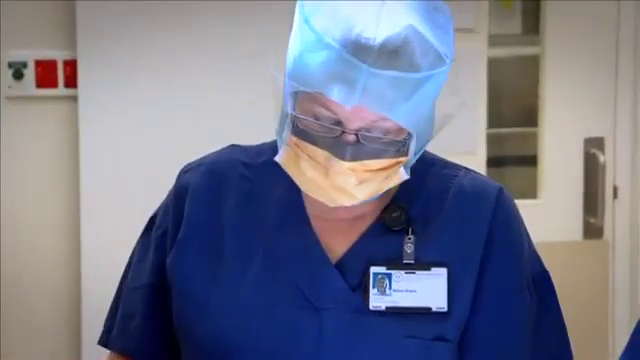


- Automatic frame caption:
 A healthcare professional is seen in a clinical setting, wearing full protective gear. The individual is dressed in blue scrubs and has a surgical mask covering their face, along with a transparent face shield and a blue hair cover. They are also wearing glasses underneath the face shield. A name badge is clipped to their scrubs, indicating their role and identity within the medical facility. The background shows a typical hospital environment with medical equipment and white walls, suggesting that the professional is engaged in a medical procedure or patient care.

- Extracted text from the frame:
 I cannot identify or extract text from the image provided.


12 Checklist step: SPECIMEN LABELING

- Summary: Ensure all specimens are correctly labeled and documented.
- Keywords: ['specimens', 'labeling', 'documentation']
- Offset in secs: 195.16
- Duration in secs: 123.12


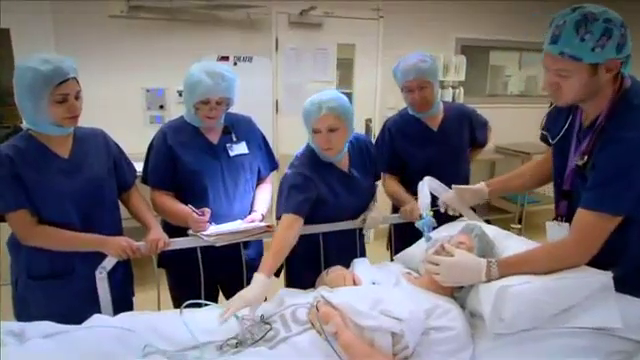


- Automatic frame caption:
 A team of medical professionals, dressed in blue scrubs and surgical caps, are gathered around a patient lying on a hospital bed. The patient is connected to various medical devices, and one of the professionals is adjusting an oxygen mask on the patient. Another professional is holding a clipboard, likely taking notes or monitoring the patient's condition. The scene appears to be in a hospital or surgical setting, with medical equipment and supplies visible in the background. The team is focused and appears to be preparing the patient for a medical procedure or surgery.

- Extracted text from the frame:
 No text is visible in the image.


13 Checklist step: RECOVERY CONCERNS

- Summary: Discuss any specific concerns regarding the patient's recovery post-operation.
- Keywords: ['recovery', 'concerns']
- Offset in secs: 215.35
- Duration in secs: 92.23


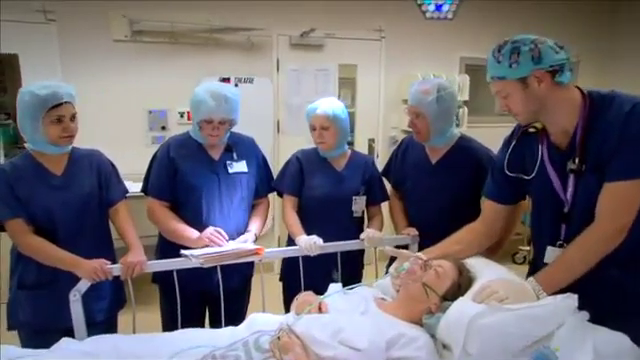


- Automatic frame caption:
 A team of medical professionals, dressed in blue scrubs, surgical caps, and gloves, are gathered around a patient lying on a hospital bed. The patient is connected to medical equipment and appears to be in a pre-operative or post-operative setting. One of the medical professionals is holding the patient's hand, providing comfort and reassurance. The room is well-lit and equipped with various medical instruments and monitors, indicating a clinical environment. The team appears focused and attentive, likely discussing the patient's care plan.

- Extracted text from the frame:
 Yale, 7, 8, 9


14 Checklist step: FINAL CHECKLIST

- Summary: Complete the pre-incision checklist and confirm all steps are done.
- Keywords: ['checklist', 'completion', 'pre-incision']
- Offset in secs: 226.68
- Duration in secs: 134.45


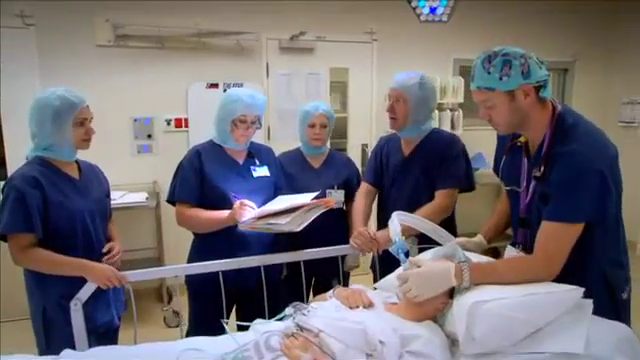


- Automatic frame caption:
 A team of medical professionals, dressed in blue scrubs and surgical caps, are gathered around a patient lying in a hospital bed. One of the team members is holding a clipboard and appears to be discussing the patient's condition or treatment plan. The patient is connected to various medical devices, including an oxygen mask and monitoring equipment. The setting is a well-equipped hospital room with medical equipment and supplies visible in the background. The atmosphere is clinical and focused, indicating a serious and attentive approach to patient care.

- Extracted text from the frame:
 I cannot extract any text from the image provided.



Powered by Azure OpenAI GPT-4o in 265.08 seconds


In [47]:
start = time.time()

json_data = json.loads(completion)["steps"]
print("\033[1;31;34m")

duration = 0

for idx, step in enumerate(json_data, start=1):
    title = str(step['Title']).upper()
    summary = step['Summary']
    keywords = step['Keywords']
    offset_secs = step['Offset_in_secs']
    duration = round(step['Offset_in_secs'] - duration, 3)
    
    # Print
    print(f"{idx} Checklist step: {title}\n")
    print(f"- Summary: {summary}")
    print(f"- Keywords: {keywords}")
    print(f"- Offset in secs: {offset_secs}")
    print(f"- Duration in secs: {duration}")
    
    # Insert frame
    display(
        Image(filename=get_video_frame(video_file,
                                       int(offset_secs) + 1)))
    
    # Automatic captionning of the frame
    print("\033[1;31;34m")
    results = gpt4o_imagefile(
        get_video_frame(video_file, int(offset_secs) + 1), 
        "Generate a detailled caption of this image."
    )
    caption = results.choices[0].message.content
    print(f"- Automatic frame caption:\n {caption}\n")
    
    # Get OCR
    results = gpt4o_imagefile(
        get_video_frame(video_file, int(offset_secs) + 1),
        "Print all the extracted text from this image separated with a comma"
    )
    ocr = results.choices[0].message.content
    print(f"- Extracted text from the frame:\n {ocr}\n\n")
    
    
elapsed = time.time() - start
print("\033[1;31;32m")
print(f"Powered by Azure OpenAI GPT-4o in {elapsed:.2f} seconds")

## 7. Export to SOP file to a .docx file <a class="anchor" id="toc7"></a>

In [48]:
start = time.time()

docx_file = checklist_docx_file(video_file, json_data, 1)

elapsed = time.time() - start
print("\033[1;31;32m")
print(f"Powered by Azure OpenAI GPT-4o in {elapsed:.2f} seconds")

Generating checklist file...

Done. Checklist file has been saved to results\surgical_sop.docx

Powered by Azure OpenAI GPT-4o in 289.81 seconds


In [49]:
display_file_info(docx_file)

File: results\surgical_sop.docx
Size: 3.56 MB
Last Modified: 2024-07-29 10:33:58


('results\\surgical_sop.docx', 3.5554676055908203, '2024-07-29 10:33:58')

In [50]:
word_link = FileLink(path=docx_file)
word_link

c:\repos\sop-doc-creation\results\surgical_sop.docx

## 8. Post processing (optional)

In [51]:
# Deleting frame files
for filename in os.listdir(FRAMES_DIR):
    file_path = os.path.join(FRAMES_DIR, filename)
    try:
        print(f"Deleting {file_path}")
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

Deleting results/frames\surgical_sop_frame_115.png
Deleting results/frames\surgical_sop_frame_119.png
Deleting results/frames\surgical_sop_frame_130.png
Deleting results/frames\surgical_sop_frame_137.png
Deleting results/frames\surgical_sop_frame_147.png
Deleting results/frames\surgical_sop_frame_16.png
Deleting results/frames\surgical_sop_frame_196.png
Deleting results/frames\surgical_sop_frame_216.png
Deleting results/frames\surgical_sop_frame_227.png
Deleting results/frames\surgical_sop_frame_41.png
Deleting results/frames\surgical_sop_frame_48.png
Deleting results/frames\surgical_sop_frame_77.png
Deleting results/frames\surgical_sop_frame_91.png
Deleting results/frames\surgical_sop_frame_99.png


> End